In [1]:
%matplotlib inline
import sys, os, copy, itertools
import numpy as np
import pandas as pd
import statsmodels.api as st
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
INDIR = r'Q:\Model Research\Swiftly\processed\v0.6\user_data'
INFILE = r'users_with_demographics.csv'
# this file contains a subset of all users who have home locations designated in Swiftly,
# tagged with demographic attributes.  Swiftly does not collect demographic attributes,
# so these are sampled from the SF-CHAMP 2015 synthetic population based on home location
# and a cross-tabulation of users by age category and gender provided by Swiftly. 
# Furthermore, user_ids cycle every 24 hours, so users were tagged with a master_user_id 
# if they were identifiable as the same user over time.  We could not match all users to 
# a master_user_id, and this analysis only focuses on those who could be identified to 
# avoid double-counting individual users or mistagging one repeat user with different 
# attributes.
user_info = pd.read_csv(os.path.join(INDIR,INFILE),low_memory=False)

In [3]:
users = user_info[pd.notnull(user_info['master_user_id'])]
users = users.drop_duplicates(subset='master_user_id')
users['hh_workers'] = users['hhfull'] + users['hhpart']
users['veh_comp'] = 0 # 0: more vehicles than workers; 1: as many vehicles as workers; 2: fewer vehicles than workers
users.loc[users['hh_workers'] < users['hhvehs'],'veh_comp'] = 0
users.loc[users['hh_workers'] == users['hhvehs'],'veh_comp'] = 1
users.loc[users['hh_workers'] > users['hhvehs'],'veh_comp'] = 2

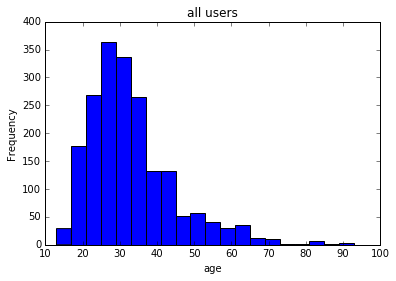

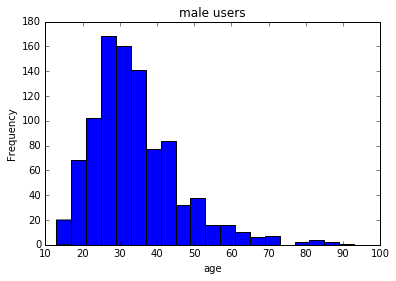

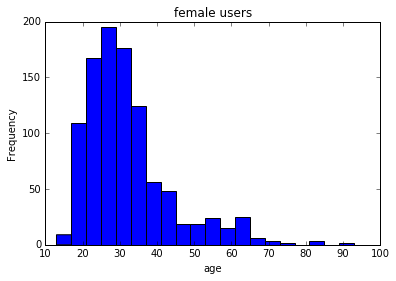

In [4]:
fig1 = plt.figure(1)
plt.title('all users')
plt.xlabel('age')
ax = users['age'].plot.hist(bins=20)
fig2 = plt.figure(2)
plt.title('male users')
plt.xlabel('age')
ax_musers = users[users['gender']==1]['age'].plot.hist(bins=20)
fig3 = plt.figure(3)
plt.title('female users')
plt.xlabel('age')
ax_fusers = users[users['gender']==2]['age'].plot.hist(bins=20)
plt.show()

In [5]:
default_float_format = pd.options.display.float_format

In [6]:
# users by age category and gender
# provided by Swiftly:
## Age    Male Female
## 13-17  1%   1%
## 18-24  9%   14%
## 25-34  21%  21%
## 35-44  11%  8%
## 45-54  5%   3%
## 55-64  2%   2%
## 65+    1%   1%
p = users.pivot_table(index='age_cat',columns='gender',values='wgt',aggfunc=np.count_nonzero)
p2 = p / p.sum().sum()
p2.columns = ['male','female']
p2 = p2.applymap(func=lambda x:'{:.1f} %'.format(x*100))
print p2

           male  female
age_cat                
13-17     1.2 %   0.8 %
18-24     8.5 %  13.8 %
25-34    21.3 %  23.3 %
35-44    10.9 %   7.3 %
45-54     4.2 %   2.4 %
55-64     1.5 %   2.8 %
65+       1.1 %   0.8 %


In [7]:
p = users.pivot_table(index='age_cat',columns='hhinc_cat',values='wgt',aggfunc=np.count_nonzero)
p2 = p / p.sum().sum()
p2 = p2.applymap(func=lambda x:'{:.1f} %'.format(x*100))
print "total users"
print p
print "percent users"
print p2

total users
hhinc_cat  $0 -$25  $25-$50  $50-$75   $75+
age_cat                                    
13-17         18.0      8.0      5.0    7.0
18-24        208.0     85.0     72.0   72.0
25-34        150.0    240.0    186.0  297.0
35-44         49.0     86.0     81.0  140.0
45-54         33.0     33.0     21.0   42.0
55-64         16.0     31.0     16.0   22.0
65+           14.0      8.0      9.0    7.0
percent users
hhinc_cat $0 -$25 $25-$50 $50-$75    $75+
age_cat                                  
13-17       0.9 %   0.4 %   0.3 %   0.4 %
18-24      10.6 %   4.3 %   3.7 %   3.7 %
25-34       7.7 %  12.3 %   9.5 %  15.2 %
35-44       2.5 %   4.4 %   4.1 %   7.2 %
45-54       1.7 %   1.7 %   1.1 %   2.1 %
55-64       0.8 %   1.6 %   0.8 %   1.1 %
65+         0.7 %   0.4 %   0.5 %   0.4 %


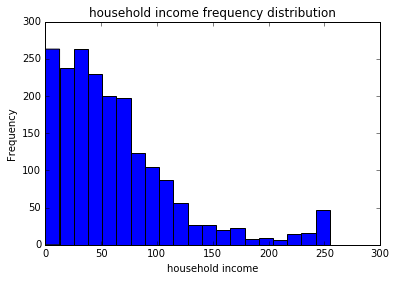

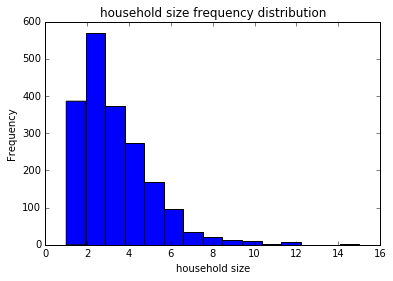

In [8]:
# household income frequency and household size frequency
fig4 = plt.figure(4)
plt.title('household income frequency distribution')
plt.xlabel('household income')
ax = users['hhinc'].plot.hist(bins=20)

fig5 = plt.figure(5)
plt.title('household size frequency distribution')
plt.xlabel('household size')
ax2 = users['hhsize'].plot.hist(bins=15)

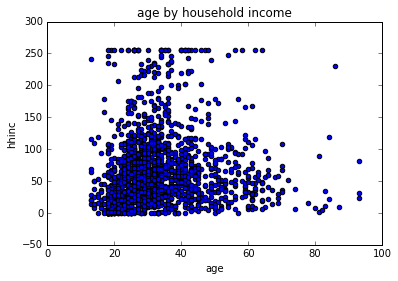

In [9]:
p = users.plot.scatter('age','hhinc',title='age by household income')

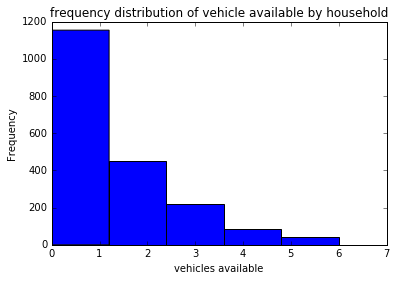

In [10]:
fig6 = plt.figure(6)
plt.title('frequency distribution of vehicle available by household')
plt.xlabel('vehicles available')
ax3 = users['hhvehs'].plot.hist(bins=5)
plt.show()


In [11]:
fig7 = plt.figure(7)


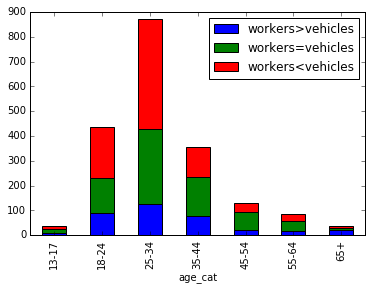

In [75]:
# frequency of vehicle availability by age category
fig = plt.figure()
p = users.pivot_table(index='age_cat',columns='veh_comp',values='wgt',aggfunc=np.count_nonzero)
p.plot.bar(stacked=True)
plt.legend(['workers>vehicles','workers=vehicles','workers<vehicles'])
plt.show()

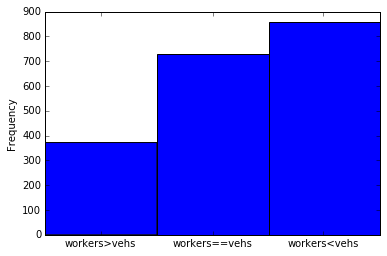

# workers by # vehicles
hhvehs        0.0    1.0    2.0   3.0   4.0   5.0  6.0
hh_workers                                            
0.0         138.0   52.0   19.0   4.0   NaN   NaN  NaN
1.0         168.0  261.0   95.0  45.0   7.0   4.0  2.0
2.0         124.0  237.0  236.0  68.0  23.0   4.0  4.0
3.0          44.0   74.0   64.0  66.0  24.0   9.0  3.0
4.0          22.0   18.0   24.0  27.0  17.0   4.0  NaN
5.0           7.0    2.0   10.0   5.0   6.0  10.0  1.0
6.0           3.0    2.0    2.0   1.0   5.0   2.0  NaN
7.0           NaN    NaN    1.0   6.0   4.0   NaN  NaN
8.0           1.0    1.0    NaN   NaN   NaN   NaN  NaN
# workers by # vehicles (percent of users)
hhvehs        0.0     1.0     2.0    3.0    4.0    5.0    6.0
hh_workers                                                   
0.0         7.1 %   2.7 %   1.0 %  0.2 %  nan %  nan %  nan %
1.0         8.6 %  13.3 %   4.9 %  2.3 %  0.4 %  0.2 %  0.1 %
2.0         6.3 %  12.1 %  12.1 %  3.5 %  1.2 %  0.2 %  0.2 %
3.0         2.2 % 

In [66]:
# Vehicle Competition
fig = plt.figure()
plt.xticks([0.33,1,1.66],['workers>vehs','workers==vehs','workers<vehs'])
ax = users['veh_comp'].plot.hist(bins=3)
plt.show()

p = users.pivot_table(index='hh_workers',columns='hhvehs',values='wgt',aggfunc=np.count_nonzero)
print "# workers by # vehicles"
print p
p2 = p / p.sum().sum()
p2 = p2.applymap(func=lambda x:'{:.1f} %'.format(x*100))
print "# workers by # vehicles (percent of users)"
print p2